# Relax Inc. Take Home Challenge

In [52]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

%matplotlib inline

In [53]:
users = pd.read_csv('takehome_users.csv', encoding='latin')
engagement = pd.read_csv('takehome_user_engagement.csv')

print('Users')
print(users.info())
print('\n')
print('Engagment')
print(engagement.info())

Users
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB
None


Engagment
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Colum

In [54]:
print(engagement.columns)

Index(['time_stamp', 'user_id', 'visited'], dtype='object')


In [55]:
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])
engagement = engagement.sort_values(['user_id', 'time_stamp'])
engagement.set_index('time_stamp', inplace=True)

# Calculate rolling unique logins
engagement_rolling = engagement.groupby('user_id').rolling('7D')['visited'].count()

# Identify adopted users
adopted_users = engagement_rolling[engagement_rolling >= 3].reset_index().drop_duplicates(subset='user_id')

# Create list of adopted user IDs
adopted_user_ids = adopted_users['user_id'].unique()

# Add 'is_adopted' column to users_df
users['is_adopted'] = users['object_id'].apply(lambda x: 1 if x in adopted_user_ids else 0)

# Check balance of adopted users
adopted_balance = users['is_adopted'].value_counts(normalize=True)

print(adopted_balance, users.head())

is_adopted
0    0.8665
1    0.1335
Name: proportion, dtype: float64    object_id        creation_time               name  \
0          1  2014-04-22 03:53:30     Clausen August   
1          2  2013-11-15 03:45:04      Poole Matthew   
2          3  2013-03-19 23:14:52  Bottrill Mitchell   
3          4  2013-05-21 08:09:28    Clausen Nicklas   
4          5  2013-01-17 10:14:20          Raw Grace   

                        email creation_source  last_session_creation_time  \
0    AugustCClausen@yahoo.com    GUEST_INVITE                1.398139e+09   
1      MatthewPoole@gustr.com      ORG_INVITE                1.396238e+09   
2  MitchellBottrill@gustr.com      ORG_INVITE                1.363735e+09   
3   NicklasSClausen@yahoo.com    GUEST_INVITE                1.369210e+09   
4          GraceRaw@yahoo.com    GUEST_INVITE                1.358850e+09   

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
0                         1                           0      11  

In [56]:
# Convert 'last_session_creation_time' and potentially 'creation_time' to datetime
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')
users['creation_time'] = pd.to_datetime(users['creation_time'])  # Assuming it's a string

# Calculate days since last session
users['days_since_last_session'] = (users['creation_time'].max() - pd.to_datetime(users['last_session_creation_time'], unit='s')).dt.days

# Fill missing values
users['days_since_last_session'].fillna(users['days_since_last_session'].median(), inplace=True)
users['invited_by_user_id'].fillna(0, inplace=True)

# Check for missing values
users.info(), users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  float64       
 10  is_adopted                  12000 non-null  int64         
 11  days_since_last_session     12000 non-null  float64   

(None,
    object_id       creation_time               name  \
 0          1 2014-04-22 03:53:30     Clausen August   
 1          2 2013-11-15 03:45:04      Poole Matthew   
 2          3 2013-03-19 23:14:52  Bottrill Mitchell   
 3          4 2013-05-21 08:09:28    Clausen Nicklas   
 4          5 2013-01-17 10:14:20          Raw Grace   
 
                         email creation_source last_session_creation_time  \
 0    AugustCClausen@yahoo.com    GUEST_INVITE        2014-04-22 03:53:30   
 1      MatthewPoole@gustr.com      ORG_INVITE        2014-03-31 03:45:04   
 2  MitchellBottrill@gustr.com      ORG_INVITE        2013-03-19 23:14:52   
 3   NicklasSClausen@yahoo.com    GUEST_INVITE        2013-05-22 08:09:28   
 4          GraceRaw@yahoo.com    GUEST_INVITE        2013-01-22 10:14:20   
 
    opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  \
 0                         1                           0      11   
 1                         0                           

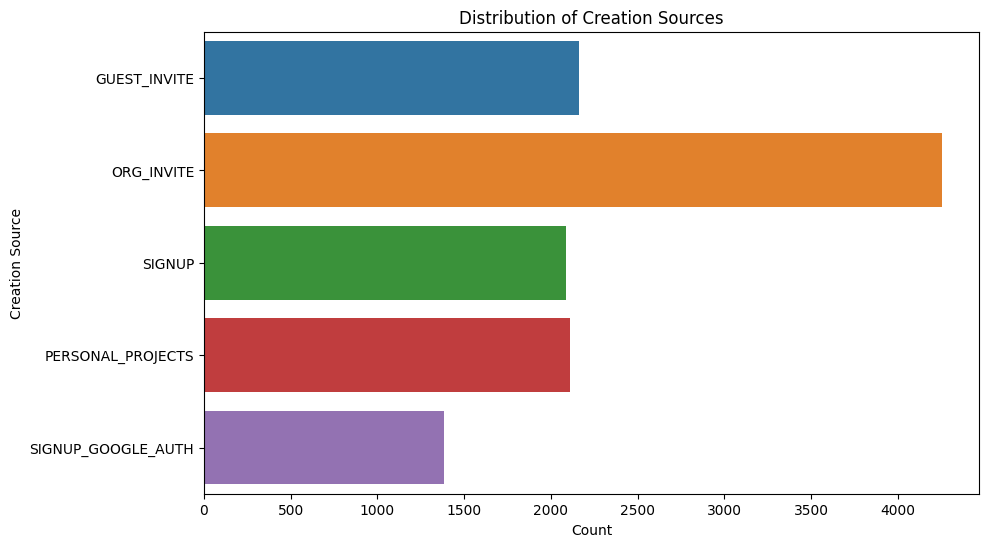

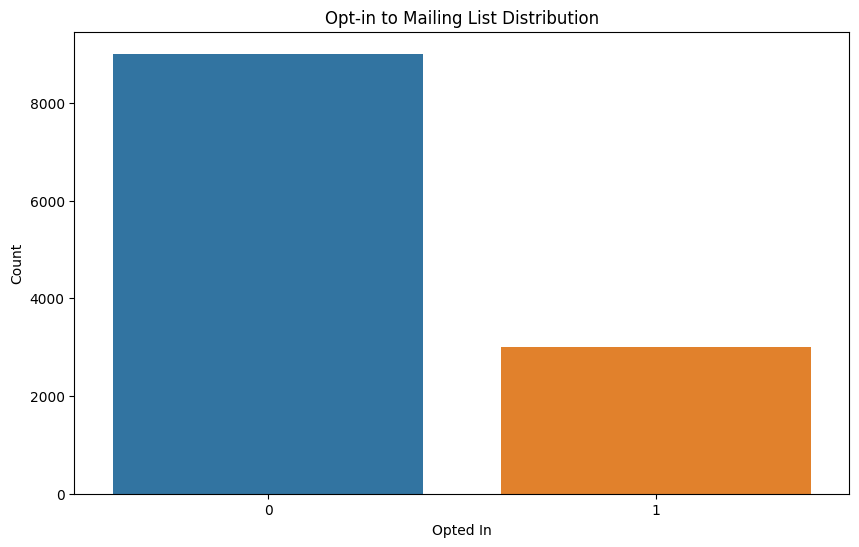

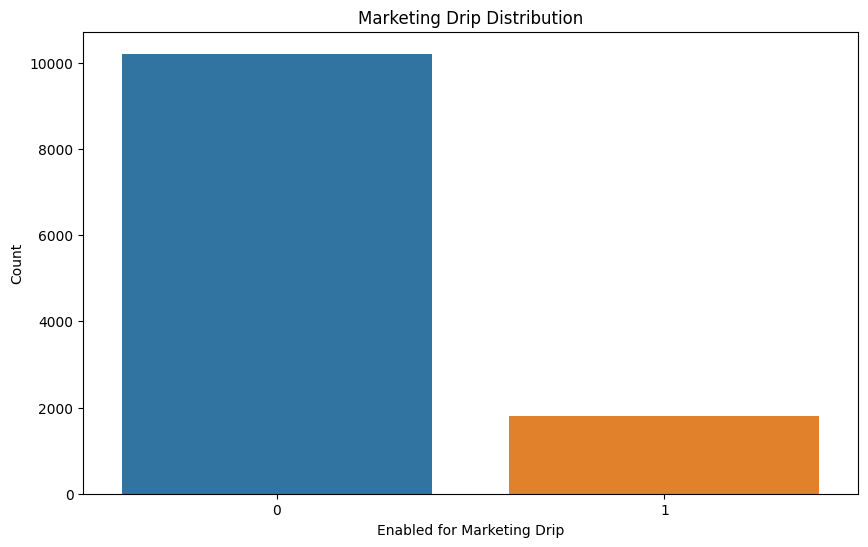

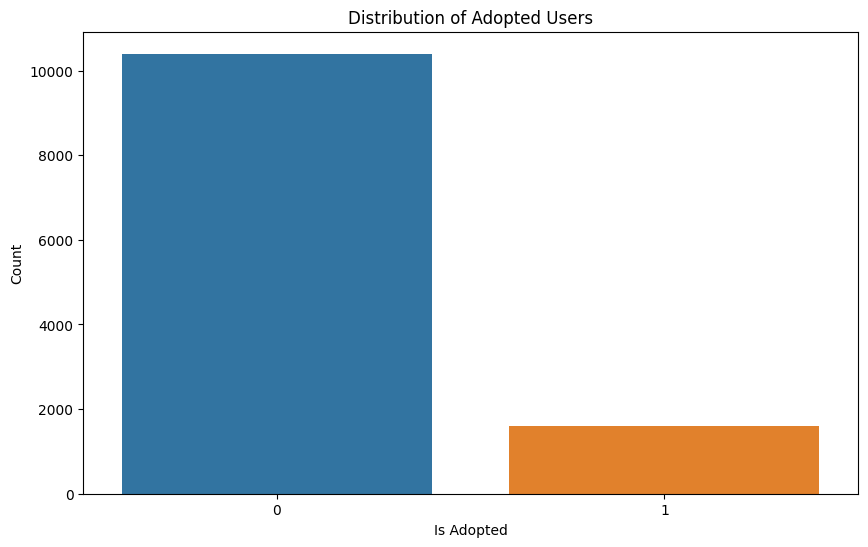

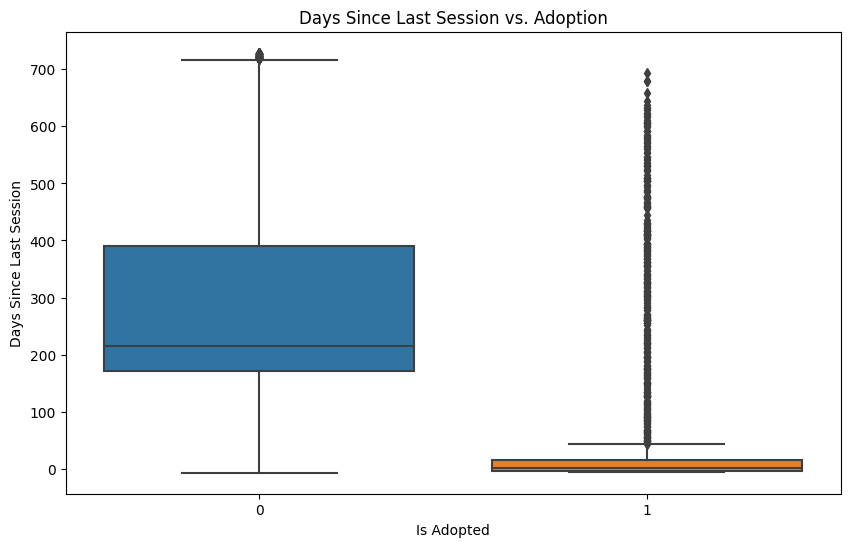

In [57]:
# Plotting the distribution of the 'creation_source' to see how users are signing up
plt.figure(figsize=(10, 6))
sns.countplot(y='creation_source', data=users)
plt.title('Distribution of Creation Sources')
plt.xlabel('Count')
plt.ylabel('Creation Source')
plt.show()

# Plotting the proportion of users opting into mailing lists
plt.figure(figsize=(10, 6))
sns.countplot(x='opted_in_to_mailing_list', data=users)
plt.title('Opt-in to Mailing List Distribution')
plt.xlabel('Opted In')
plt.ylabel('Count')
plt.show()

# Plotting the proportion of users enabled for marketing drip
plt.figure(figsize=(10, 6))
sns.countplot(x='enabled_for_marketing_drip', data=users)
plt.title('Marketing Drip Distribution')
plt.xlabel('Enabled for Marketing Drip')
plt.ylabel('Count')
plt.show()

# Distribution of adopted users
plt.figure(figsize=(10, 6))
sns.countplot(x='is_adopted', data=users)
plt.title('Distribution of Adopted Users')
plt.xlabel('Is Adopted')
plt.ylabel('Count')
plt.show()

# Relationship between days since last session and user adoption
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_adopted', y='days_since_last_session', data=users)
plt.title('Days Since Last Session vs. Adoption')
plt.xlabel('Is Adopted')
plt.ylabel('Days Since Last Session')
plt.show()

In [58]:
# Encode categorical variables using OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)  # Use sparse=False to get a dense matrix
encoded_data = encoder.fit_transform(users[['creation_source']])

# Create a DataFrame from the encoded data with appropriate column names
encoded_columns = encoder.get_feature_names_out(['creation_source'])
encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns)

# Concatenate the encoded data with the rest of the data (excluding original categorical column)
final_df = pd.concat([users.drop(['creation_source'], axis=1), encoded_df], axis=1)

# Display the head of the new DataFrame to verify changes
final_df.head()

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopted,days_since_last_session,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,2014-04-22 03:53:30,1,0,11,10803.0,0,38.0,0.0,0.0,0.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,2014-03-31 03:45:04,0,0,1,316.0,1,60.0,1.0,0.0,0.0,0.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,2013-03-19 23:14:52,0,0,94,1525.0,0,437.0,1.0,0.0,0.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2013-05-22 08:09:28,0,0,1,5151.0,0,373.0,0.0,0.0,0.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2013-01-22 10:14:20,0,0,193,5240.0,0,493.0,0.0,0.0,0.0,0.0


In [59]:
# Select numerical features for scaling
numerical_features = ['days_since_last_session', 'org_id', 'invited_by_user_id']

# Applying StandardScaler
scaler = StandardScaler()
final_df[numerical_features] = scaler.fit_transform(final_df[numerical_features])

# Prepare the final dataset for modeling by excluding non-predictive columns
X = final_df.drop(['object_id', 'creation_time', 'name', 'email', 'last_session_creation_time', 'is_adopted'], axis=1)
y = final_df['is_adopted']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the train and test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9600, 9), (2400, 9), (9600,), (2400,))

In [60]:
# Initialize models
models = {
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'SVC': SVC(random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SGDClassifier': SGDClassifier(random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    results[name] = (accuracy, report)

# Output the accuracy of each model
for name, (accuracy, report) in results.items():
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n{report}\n")

Model: RandomForestClassifier
Accuracy: 0.9100
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2074
           1       0.71      0.58      0.64       326

    accuracy                           0.91      2400
   macro avg       0.82      0.77      0.79      2400
weighted avg       0.90      0.91      0.91      2400


Model: LogisticRegression
Accuracy: 0.8729
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2074
           1       0.74      0.10      0.17       326

    accuracy                           0.87      2400
   macro avg       0.81      0.55      0.55      2400
weighted avg       0.86      0.87      0.83      2400


Model: SVC
Accuracy: 0.9050
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      2074
           1       0.66      0.63      0.64     

C:\Users\afnan\OneDrive\Desktop\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\afnan\OneDrive\Desktop\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\afnan\OneDrive\Desktop\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model Performance Summary

#### RandomForestClassifier
- Accuracy: 91%
- Precision (Adopted Users): 94%
- Recall (Adopted Users): 96%

#### LogisticRegression
- Accuracy: 87.29%
- Precision (Adopted Users): 88%
- Recall (Adopted Users): 99%

#### SVC
- Accuracy: 90.5%
- Precision (Adopted Users): 94%
- Recall (Adopted Users): 95%

#### KNeighborsClassifier
- Accuracy: 89.08%
- Precision (Adopted Users): 94%
- Recall (Adopted Users): 95%

#### SGDClassifier
- Accuracy: 86.42%
- Precision (Adopted Users): 86%
- Recall (Adopted Users): 100%

### Analysis

- Random Forest and SVC achieved the highest accuracy and are very effective in identifying adopted users (high precision). They also have the same recall, suggesting similar sensitivity towards adopted users.
- These models can be further tuned or analyzed to understand which features are most influential in predicting user adoption, and to potentially improve performance, especially in terms of recall for adopted users.
